In [35]:
from dolfin import *
from configparser import ConfigParser
import numpy as np
import meshio

### конвертация сетки в xdmf

In [36]:
input_dir_name = "meshes/meshmesh_output/"
input_mesh_name = "result"
input_path_to_msh = input_dir_name + input_mesh_name

In [37]:
output_dir_name = "meshes/xdmf/"
output_mesh_name = "result"
output_path_to_msh = output_dir_name + output_mesh_name

In [38]:
msh = meshio.read(input_path_to_msh + ".msh")

tet_data = msh.cell_data_dict["gmsh:physical"]["tetra"]
meshio.write(output_path_to_msh +".xdmf",
    meshio.Mesh(points=msh.points,
        cells={"tetra": msh.cells_dict["tetra"]},
        cell_data={"dom_marker": [tet_data]}
    )
)

print(msh.cell_data_dict.keys())
print(msh.cell_data_dict["gmsh:physical"].keys())
print(msh.cell_data_dict["gmsh:geometrical"].keys())

tri_data = msh.cell_data_dict["gmsh:physical"]["triangle"]
meshio.write(output_path_to_msh +"_surf.xdmf",
    meshio.Mesh(points=msh.points,
        cells={"triangle": msh.cells_dict["triangle"]},
        cell_data={"bnd_marker": [tri_data]}
    )
)


dict_keys(['gmsh:physical', 'gmsh:geometrical'])
dict_keys(['triangle', 'tetra'])
dict_keys(['triangle', 'tetra'])


In [39]:
mesh = Mesh()
with XDMFFile(output_path_to_msh + ".xdmf") as infile:
    infile.read(mesh)
mvc_3d = MeshValueCollection("size_t", mesh, 3) 
with XDMFFile(output_path_to_msh + ".xdmf") as infile:
    infile.read(mvc_3d, "dom_marker")
mf_3d = cpp.mesh.MeshFunctionSizet(mesh, mvc_3d)

mvc_2d = MeshValueCollection("size_t", mesh, 2)
with XDMFFile(output_path_to_msh + "_surf.xdmf") as infile:
    infile.read(mvc_2d, "bnd_marker")
mf_2d = cpp.mesh.MeshFunctionSizet(mesh, mvc_2d)

In [40]:
surfaces = list(set(tri_data))
volums = list(set(tet_data))

print('Фасеты', surfaces)
print('Объемы ', volums)

Фасеты [1001, 1002, 1003, 1005, 1006, 1007, 1008, 1009, 1010]
Объемы  [1, 2, 3, 5, 6, 7, 8, 9, 10]


## решение уравнения пуассона
### начальные условия

In [41]:
initial_teperatures = {1001: 37.2, 1002: 37, 1003: 35.5, 1005: 31, 1006: 34, 1007: 34, 1008: 34, 1009: 37, 1010: 37}

In [42]:
V = FunctionSpace(mesh, 'CG', 1)

bcs = [DirichletBC(V, Constant(t0), mf_2d, id) for id, t0 in initial_teperatures.items()]

In [43]:
u = TrialFunction(V)
v = TestFunction(V)
f = Constant(0.0)
a = dot(grad(u), grad(v))*dx
L = f*v*dx
w = Function(V)

In [44]:
solve(a == L, w, bcs, solver_parameters={'linear_solver':'mumps'})

file = XDMFFile("solutions/poisson_solution.xdmf")
file.write(w)

Solving linear variational problem.


### решение уравнения теплопроводности

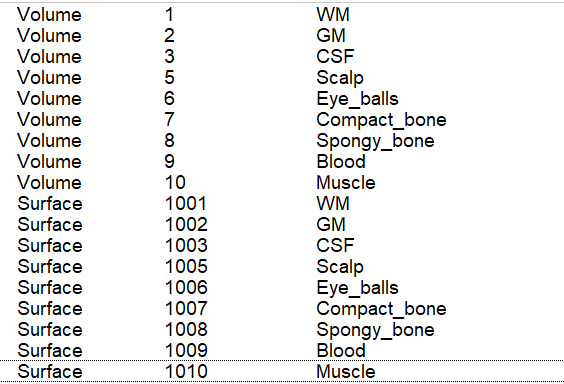
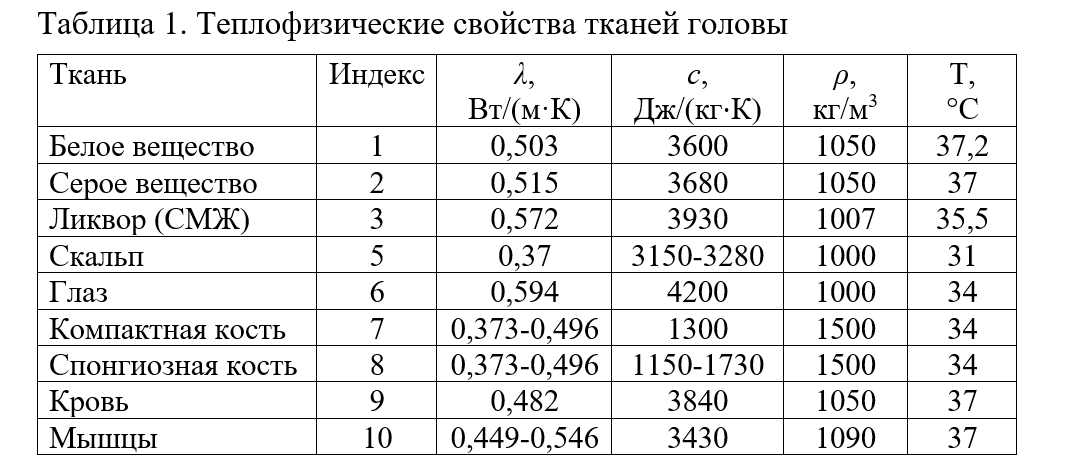

In [45]:
T0 = Constant(10.0)
h = 6*10**-3
region_densities =      {1: 1050,  2: 1500,  3: 1007,   5: 1000,   6: 1000,  7:1500,    8:1500,   9:1050,    10:1090}#p
region_hcs =            {1: 3600,  2: 3680,  3: 3930,   5: 3200,   6: 4200,  7:1300,    8:1500,   9:3840,    10:3430}#C
region_conductivities = {1: 0.503, 2: 0.515, 3: 0.572,  5: 0.37,   6: 0.594, 7:0.400,   8:0.400,  9:0.482,   10:0.500}#k
#initial_t =             {1: 37.2, 2: 37, 3: 35.5, 5: 31, 6: 34, 7: 34, 8: 34, 9: 37, 10: 37, }
initial_value = 37.2 

In [46]:
dt = 600
u_n = w


ds = Measure('ds', domain=mesh, subdomain_data=mf_2d)
dx = Measure("dx", domain=mesh, subdomain_data=mf_3d) 
u = TrialFunction(V)
v = TestFunction(V)
f = Constant(0)

In [47]:
a = 0
L = 0

for subdomain_id in region_densities.keys():
    p = region_densities[subdomain_id] /10**6
    C = region_hcs[subdomain_id]
    k = region_conductivities[subdomain_id]
    a += p*C*u*v*dx(subdomain_id) + dt*k*dot(grad(u), grad(v))*dx(subdomain_id)
    L += p*C*u_n*v*dx(subdomain_id) + dt*f*v*dx(subdomain_id)
    # добавление фасетов (не уверен - не влияет, в dx учитываются только объемы)
    a += p*C*u*v*dx(subdomain_id + 1000) + dt*k*dot(grad(u), grad(v))*dx(subdomain_id + 1000)
    L += p*C*u_n*v*dx(subdomain_id + 1000) + dt*f*v*dx(subdomain_id + 1000)

a += dt*h*u*v*ds(1005)
L += dt*h*T0*v*ds(1005)
# не влияет, в ds учитываются только фасеты 
a += dt*h*u*v*ds(5)
L += dt*h*T0*v*ds(5)

In [48]:
point = [0.5, 0.5, 0.5] # точка примерно в центре головы (самая теплая)
pts = []
vals = []

In [49]:
vfile = File('results/vel.pvd')


# Time-stepping
tmp = Function(V)
t = 0
for n in range(24*60*60//dt+1):

    # Update current time
    t += dt

    # Compute solution
    solve(a == L, tmp, solver_parameters={'linear_solver':'mumps'})


    pts.append(t/60/60)
    val = tmp(point)
    vals.append(val)
    
    vfile << tmp

    # Update previous solution
    u_n.assign(tmp)
    print('value:', t/60/60, n, val)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Solving linear variational problem.
value: 0.16666666666666666 0 37.05769244813125
Solving linear variational problem.
value: 0.3333333333333333 1 36.92739241215223
Solving linear variational problem.
value: 0.5 2 36.765540511668604
Solving linear variational problem.
value: 0.6666666666666666 3 36.565072764441766
value: 0.8333333333333334 4 36.32390213447905
Solving linear variational problem.
Solving linear variational problem.
value: 1.0 5 36.04315038136425
Solving linear variational problem.
value: 1.1666666666666667 6 35.725879685547
Solving linear variational problem.
value: 1.3333333333333333 7 35.37617036172086
Solving linear variational problem.
value: 1.5 8 34.99849643424933
Solving linear variational problem.
value: 1.6666666666666667 9 34.59733568768634
Solving linear variational problem.
value: 1.8333333333333333 10 34.176943915500594
Solving 

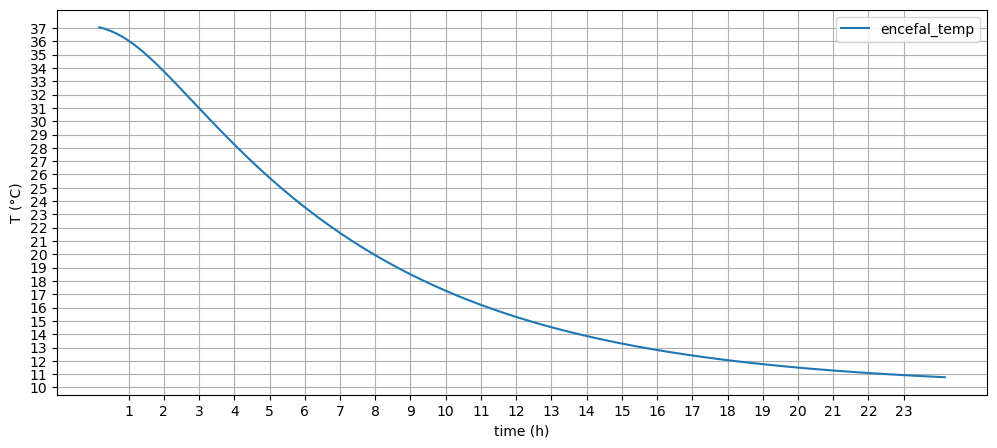

In [50]:
import matplotlib.pyplot as plt
plt.plot(pts, vals)
plt.xlabel('time (h)')
plt.ylabel('T (°C)')
plt.legend(['encefal_temp'])
plt.gcf().set_size_inches(12, 5)
plt.yticks(np.arange(10, 37.5, 1))
plt.xticks(np.arange(1, 24, 1))
plt.grid ( True )